In [1]:
import numpy as np
from scipy.special import lambertw 
from scipy.stats import gmean
import matplotlib
import random
import torch as th
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)
from scipy import optimize
import pickle
import os
import tqdm

In [2]:
from numpy import linalg as LA
from scipy import *
import scipy.linalg as sp
import tqdm
import matplotlib.pyplot as plt
import pickle

In [45]:
def init_ray_prob(avg_tangent_, n =1):
    
    ignorance = np.ones((50000,10))*0.1
    p_n = ignorance + avg_tangent_*n
    p_n  /= np.sum(p_1,1,keepdims = True)

    return p_n


def final_ray_prob(avg_tangent_, pos,n =1):
    
    p_n = pos + avg_tangent_*n
    p_n  /= np.sum(p_1,1,keepdims = True)

    return p_n


def numerical_deriv(y,i,winlen):
    derivative_ = 0
    for j in range(1,winlen):
        derivative_ +=(y[i+j,:,:]-y[i-j,:,:])/(2*j)
    return derivative_/(winlen-1)


In [3]:


def dbhat(x1, x2, reduction='mean', dev='cuda', debug=False, chunks=1000):
    "from jialin's repo"
    # x1, x2 shape (num_points, num_samples, num_classes)
    np1, ns, _ = x1.size()
    np2, ns, _ = x2.size()
   
    x1, x2 = x1.transpose(0, 1), x2.transpose(0, 1)
    w = np.zeros([np1, np2])

    chunks = chunks or 1;
    for aa in tqdm.tqdm(th.chunk(th.arange(ns), chunks)):
        xx1 = x1[aa, :].to(dev)
        xx2 = x2[aa, :].to(dev)
        aa = th.sqrt(aa)
        w_ = -th.log(th.bmm(th.sqrt(xx1), th.sqrt(xx2).transpose(1, 2)))
        w_[w_ > 1e12] = 10e6
        w_[w_ < 0] = 0
        w += w_.sum(0).cpu().numpy()
    if reduction == 'mean':
        return w/ns
    else:
        return w

def dist_projection_clumsy(xp1,xp2,metric_sig,dim=3):
    '''
    find the distance between two points in an embedding
    '''
    ns1,nd1 = xp1.shape
    ns2,nd2 = xp2.shape
    
    dists_ = np.zeros((ns1,ns2))
    for n1 in tqdm.tqdm(range(ns1)):
        for n2 in range(ns2):
            dists_[n1,n2] = np.sum(metric_sig[:dim]*(xp1[n1,:dim]-xp2[n2,:dim])**2)
    return dists_

def projection(Dbhatt):
    """
    From jialin's proj function
    """
    ne = 1000 
    n = Dbhatt.shape[0]
    l = np.eye(Dbhatt.shape[0]) - 1.0/Dbhatt.shape[0]
    w = -l @ Dbhatt @ l / 2

    #e1, v1 = sp.eigh(w, driver='evx', check_finite=False,
    #                 subset_by_index=[n-(ne+1), n-1])
    #e2, v2 = sp.eigh(w , driver='evx', check_finite=False,
    #                 subset_by_index=[0, (ne+1)])
    #e = np.concatenate((e1, e2))
    #v = np.concatenate((v1, v2), axis=1)
    e, v = LA.eigh(w)
    
    ii = np.argsort(np.abs(e))[::-1]
    e, v = e[ii], v[:, ii]
    
    xp = v*np.sqrt(np.abs(e))
    
    return xp, e, v

def new_points_in_embedding(new_points, p_list, dist_mat, eig_values, eig_vecs, distance = dbhat, embed_dimension =3):
    """
    From Itay's function 
    
    - slight modification for efficiency 
    
    """
    # using jialin's dbhatt/ diskl function 
    dp=distance(th.Tensor(new_points),th.Tensor(p_list),chunks= 20000)   
        
    d_mean=np.mean(dist_mat,0)
    d_mean_mean=np.mean(d_mean)
    dp_mean=dp-np.mean(dp)-d_mean+d_mean_mean
    dp_mean=-.5*dp_mean
    sqrtsigma=np.sign(eig_values)*np.sqrt(np.abs(eig_values))
    
    return ((1/sqrtsigma)*np.matmul(dp_mean,eig_vecs))


def linear_interp_ignorance_to_truth(lambda_,truth_,num_class=10):
    # lambda_ is a tuning param along the linearly interpolated path
    # grounnd truth is an array that contains the ground truth label of images nx1 array
    # randsample is an array of the indices sampled from N images
    # num_class is the number of labels 
    
    num_sample = truth_.shape[0]
    # create ignorance distributions
    ignorance_ = np.ones((num_sample,num_class))/num_class
    # compute dG
    dG = 2*np.arccos(np.sum(np.sqrt(ignorance_)*np.sqrt(truth_),1)).reshape(-1,1)
    # compute linear interpolation
    interp_ = np.sin((1-lambda_)*dG/2)*np.sqrt(ignorance_)/np.sin(dG/2) + np.sin(lambda_*dG/2)*np.sqrt(truth_)/np.sin(dG/2)
    return (interp_)**2

In [4]:
t_jialin = np.array([    0,     1,    63,   125,   187,   249,   251,   313,   375,
      437,   499,   501,   563,   625,   687,   749,   751,   813,
      875,   937,   999,  1001,  1063,  1125,  1187,  1249,  1500,
     1750,  2000,  2250,  2500,  2750,  3000,  3250,  3500,  3750,
     4000,  4250,  4500,  4750,  5000,  5250,  5500,  5750,  6000,
     6250,  6500,  7250,  8250,  9250, 10250, 11250, 12250, 13250,
    14250, 15250, 16250, 19000, 22750, 26500, 30250, 34000, 37750,
    41500, 45250, 49000, 50000])
t_save = set(list(np.arange(1000))+list(t_jialin) + list(np.arange(15000,35000,20)))
t_save = list(t_save)
t_save.sort()
 
jialin_ind = [np.where(t_save==k)[0][0] for k in t_jialin]

In [5]:
save_path = r'D:\inpca_data\results\bootstrap_avg_models\allcnn'
p_list= pickle.load(open(os.path.join(save_path,'p_list_new.p'), 'rb')) 


In [6]:
init_ray_list = th.Tensor(pickle.load(open(r'C:\Users\Itay\Documents\ipcaLocal\init_rays.p','rb')))
final_ray_list = th.Tensor(pickle.load(open(r'C:\Users\Itay\Documents\ipcaLocal\final_rays.p','rb')))
ig2truth_ray= th.Tensor(pickle.load(open(r'C:\Users\Itay\Documents\ipcaLocal\ig2truth_rays.p','rb')))
p_list_rays = th.concat((init_ray_list,final_ray_list,ig2truth_ray),axis=0)


In [7]:
Dbhatt = dbhat(p_list_rays, p_list_rays, chunks=20000)
pickle.dump(Dbhatt,open(r'C:\Users\Itay\Documents\ipcaLocal\dbhat_tangent.p','wb'))

100%|██████████████████████████████████████████████████████████████████████████| 16667/16667 [00:06<00:00, 2570.84it/s]


In [21]:
Dbhatt_data = dbhat(p_list, p_list, chunks=20000)
pickle.dump(Dbhatt_data,open(r'C:\Users\Itay\Documents\ipcaLocal\dbhat_data.p','wb'))

100%|████████████████████████████████████████████████████████████████████████████| 16667/16667 [03:02<00:00, 91.29it/s]


In [22]:
xp_data, e_data, v_data = projection(Dbhatt_data)


In [8]:
xp, e, v = projection(Dbhatt)

In [9]:
xp_extend = new_points_in_embedding(p_list,th.concat((init_ray_list,final_ray_list,ig2truth_ray),axis=0), Dbhatt, e, v)
pickle.dump(xp_extend,open(r'C:\Users\Itay\Documents\ipcaLocal\embedded_pts_in_tangent.p','wb'))

100%|███████████████████████████████████████████████████████████████████████████| 16667/16667 [00:21<00:00, 787.07it/s]


# % Actual Distance Captured 

In [10]:
dbhatt_actual = dbhat(p_list,p_list)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 41.40it/s]


In [11]:
dists_test = dist_projection_clumsy(xp_extend,xp_extend,np.sign(e))

100%|█████████████████████████████████████████████████████████████████████████████| 2010/2010 [00:12<00:00, 166.76it/s]


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


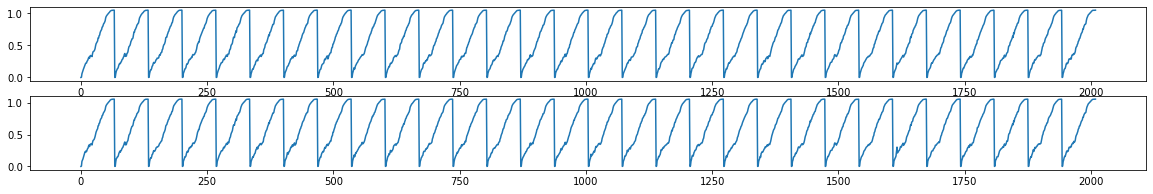

In [12]:
%matplotlib inline
plt.figure(figsize=(20,3))
plt.subplot(2,1,1)
plt.plot(dists_test[0])
plt.subplot(2,1,2)
plt.plot(dbhatt_actual[0])

In [40]:
n_dim = 10
explained_var = []
for d in range(1,n_dim):
    dists_test = dist_projection_clumsy(xp_extend,xp_extend,np.sign(e),dim=d)

    explained_var.append(1-(dbhatt_actual-dists_test).sum()/dbhatt_actual.sum())

100%|█████████████████████████████████████████████████████████████████████████████| 2010/2010 [00:11<00:00, 169.94it/s]


In [41]:
n_dim = 10
explained_var_data= []
for d in range(1,n_dim):
    d_proj_clumsy = dist_projection_clumsy(xp_data,xp_data,np.sign(e_data),dim=d)

    explained_var_data.append(1-(dbhatt_actual-d_proj_clumsy).sum()/dbhatt_actual.sum())


100%|█████████████████████████████████████████████████████████████████████████████| 2010/2010 [00:11<00:00, 172.02it/s]


Inpca tangent


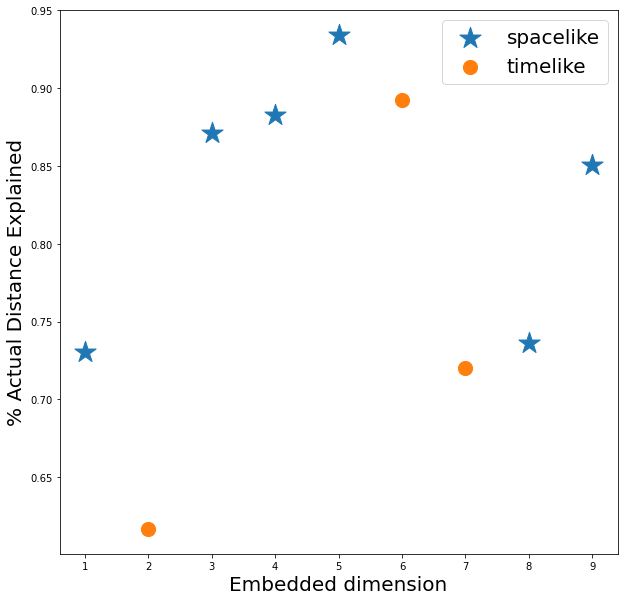

In [42]:
plt.figure(figsize=(10,10))
space_cond = np.sign(e[:n_dim-1])>0
plt.scatter(np.arange(1,n_dim)[space_cond],np.array(explained_var)[space_cond],label='spacelike',s=500,marker='*')
plt.scatter(np.arange(1,n_dim)[~space_cond],np.array(explained_var)[~space_cond],label='timelike',s=200)
plt.legend(fontsize=20)
plt.xlabel('Embedded dimension',fontsize= 20)
plt.ylabel('% Actual Distance Explained',fontsize= 20)
plt.savefig('Actual_distance_explained.png', dpi=300)

Inpca data

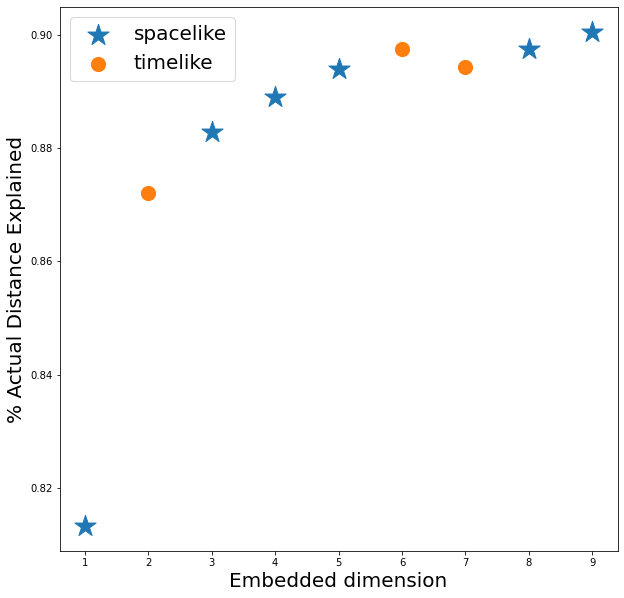

In [43]:
plt.figure(figsize=(10,10))
space_cond = np.sign(e[:n_dim-1])>0
plt.scatter(np.arange(1,n_dim)[space_cond],np.array(explained_var_data)[space_cond],label='spacelike',s=500,marker='*')
plt.scatter(np.arange(1,n_dim)[~space_cond],np.array(explained_var_data)[~space_cond],label='timelike',s=200)
plt.legend(fontsize=20)
plt.xlabel('Embedded dimension',fontsize= 20)
plt.ylabel('% Actual Distance Explained',fontsize= 20)
plt.savefig('Actual_distance_explained_data.png', dpi=300)

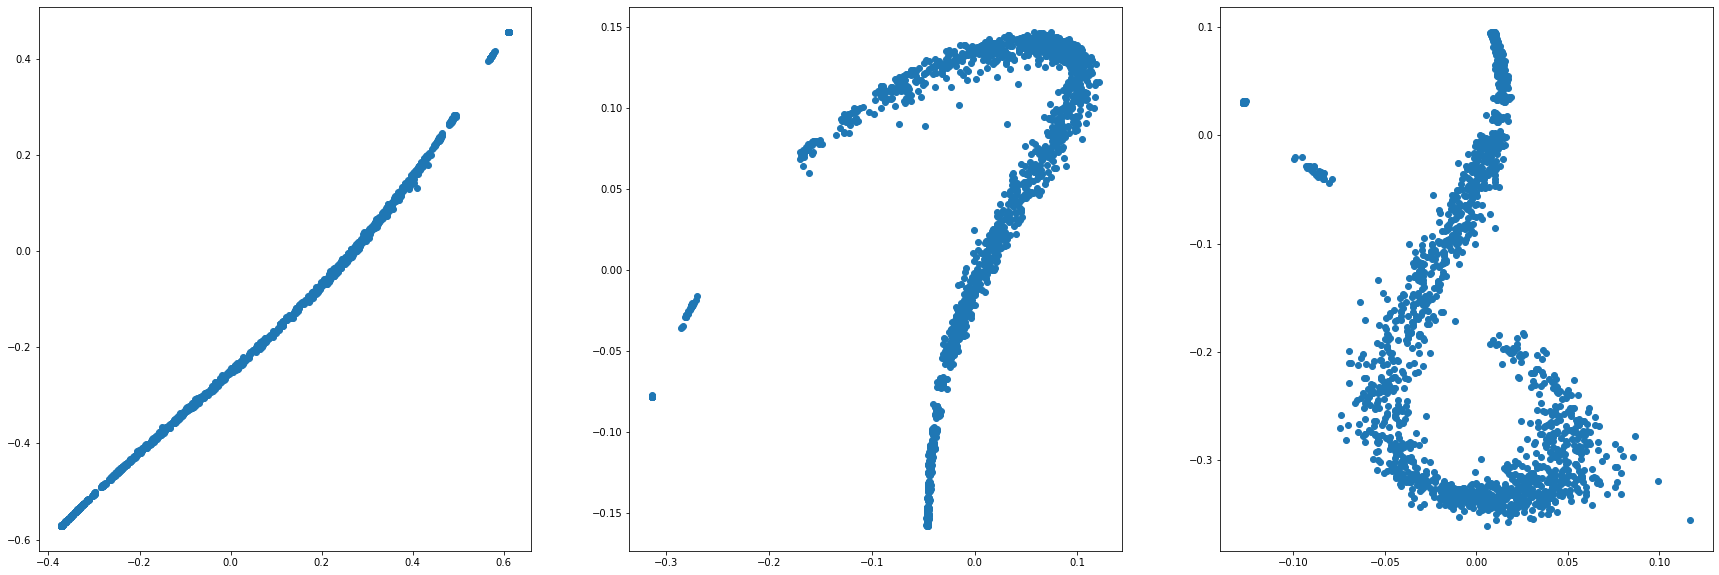

In [35]:
%matplotlib inline
plt.figure(figsize=(30,10))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.scatter(xp_data[:,i],xp_extend[:,i])


<IPython.core.display.Javascript object>


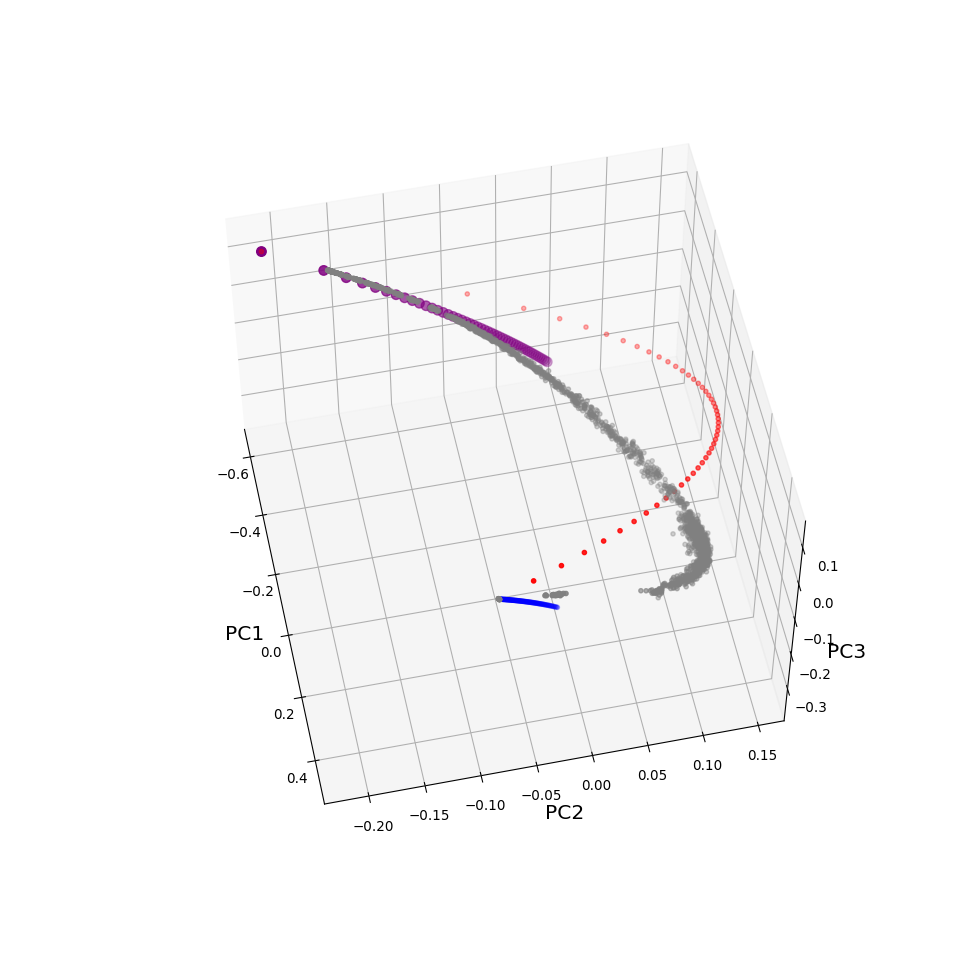

In [19]:
%matplotlib notebook
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xp_extend[:,0],xp_extend[:,1],xp_extend[:,2],s=10,c='gray')
ax.scatter(xp[:50,0],xp[:50,1],xp[:50,2],s=10,c='b')
ax.scatter(xp[50:100,0],xp[50:100,1],xp[50:100,2],s=50,c='purple')
ax.scatter(xp[100:,0],xp[100:,1],xp[100:,2],s=10,c='r')

ax.set_xlabel('PC1',fontsize=15)
ax.set_ylabel('PC2',fontsize=15)
ax.set_zlabel('PC3',fontsize=15)
plt.savefig('Tangent_embedding.png', dpi=300)